# Xây dựng mô hình học máy và so sánh hiệu quả giữa chúng

In [1]:
%cd /content/drive/MyDrive/DS-DM-Project

/content/drive/MyDrive/DS-DM-Project


In [2]:
%pip install pyvi

## Import thư viện cần dùng

In [74]:
# System library
import os
import warnings

# Statistics library
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Natural Language Toolkit
import nltk
import gensim
from pyvi import ViUtils, ViTokenizer

# Machine Learning
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [4]:
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 10)})
np.random.seed(42)

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần I: Phân tích, tiền xử lý
Trong phần này, chúng ta sẽ tiến hành các bước để phân tích cơ bản về dữ liệu thu được và tiền xử lý chúng trước khi cho vào các mô hình học máy để tiến hành học

### Đọc các dữ liệu cần dùng

In [5]:
# read dantri.json file
dantri = pd.read_json(os.path.join(DATA_PATH, 'dantri.json'))

# read vietnamese stopwords
with open(os.path.join(DATA_PATH, 'vietnamese-stopwords.txt'), 'r') as f:
  stopwords = [line.rstrip("\n").strip().replace(' ', '_') for line in f]

In [6]:
# print first 5 object
dantri.head()

,title,category,content
0,"Thi hành án dứt điểm những vụ lớn, phức tạp li...",Xã hội,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c..."
1,"Món quà của Thủ tướng dành cho những người ""kh...",Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
2,Thủ tướng thị sát đường sắt Nhổn - ga Hà Nội: ...,Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
3,Đại sứ Saudi Arabia: Mong muốn Việt Nam sớm vư...,Xã hội,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...
4,"Tổng Thanh tra Chính phủ nói về giải pháp ""trị...",Xã hội,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...


In [7]:
# remove `Nhân ái` class
dantri = dantri[dantri['category'] != 'Nhân ái']

In [8]:
# print first 5 words in stopwords
stopwords[:5]

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy']

### Phân tích và tiền xử lý

In [9]:
print(f"Dataset gồm {dantri.shape[0]} dữ liệu và {dantri.shape[1]} thuộc tính")

Dataset gồm 13331 dữ liệu và 3 thuộc tính


#### Remove NaN values

In [10]:
dantri.isna().sum()

title       0
category    0
content     0
dtype: int64

Dữ liệu trên không có giá trị nào NaN cả nên chúng ta không cần phải loại bỏ chúng

In [11]:
data = dantri[['content', 'category']]

Tổng có 15 hạng mục được thu về, tuy nhiên, có những bài báo rất ngắn vì nó chứa video, vì vậy chúng ta có thể chọn ra ngưỡng cho từng hạng mục để tránh việc bị Overfitting

#### Biểu đồ cột phân bố số lượng bài báo trên từng hạng mục

In [12]:
count = data["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)
num_of_post_each_topic

,category,count
0,Thể thao,1497
1,Giáo dục,1414
2,Sức khỏe,1270
3,Bất động sản,1229
4,Kinh doanh,1102
5,Văn hóa,1044
6,Xã hội,967
7,Xe ++,910
8,Sức mạnh số,800
9,Thế giới,759


In [13]:
fig = px.histogram(
    num_of_post_each_topic,
    x='category',
    y='count',
    color='category',
    title="Số lượng bài báo trên từng hạng mục",
    color_discrete_sequence=px.colors.qualitative.Light24,
    opacity=0.75
)
fig.update_yaxes(showgrid=True)  # the y-axis is in dollars
fig.update_layout(  # customize font and legend orientation & position
    font_family="Arial",
    legend=dict(
        title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ),
    yaxis_title="Số lượng bài báo",
    xaxis_title="Hạng mục",
)


fig.add_shape(  # add a horizontal "target" line
    type="line",
    line_color="#16FF32",
    line_width=3,
    opacity=1,
    line_dash="dot",
    x0=0,
    x1=1,
    xref="paper",
    y0=929,
    y1=929,
    yref="y",
)

fig.add_annotation(  # add a text callout with arrow
    text="Số lượng ít nhất", x="Pháp luật", y=500, arrowhead=1, showarrow=True
)


fig.show()

Với biểu đồ cột ở trên, thấy rằng phân bố `số lượng bài báo` trên từng `hạng mục` là không đồng đều nhau. Điều này có nghĩa là khi chia ngẫu nhiên dữ liệu để xây dựng mô hình có thể xảy ra tình trạng **Imbalanced Data** vì số lượng bài báo của hạng mục đầu tiên trên trung bình mẫu (đường màu xanh) đã gấp hơn 2 lần so với số lượng bài báo thấp nhất (đường mũi tên).

Từ những nhận xét sơ cấp ở trên, chúng ta có thể xem xét đến hiệu suất của mô hình khi đã qua xử lý việc mất cân bằng dữ liệu

In [14]:
categories = data['category'].unique()
categories

array(['Xã hội', 'Việc làm', 'An sinh', 'Văn hóa', 'Thế giới',
       'Kinh doanh', 'Bất động sản', 'Sức mạnh số', 'Thể thao',
       'Sức khỏe', 'Giải trí', 'Giáo dục', 'Xe ++', 'Pháp luật'],
      dtype=object)

In [15]:
data['len'] = data['content'].str.len()
data.head()

,content,category,len
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,2825
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3688
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3759
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,5821
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,4660


In [16]:
def create_hist_plot(categories: list[str], df):
  fig, ax = plt.subplots(1, 3)
  for idx, category in enumerate(categories):
    df_category = df.query(f"`category` == '{category}'")
    sns.histplot(data=df_category, x="len", kde=True, ax=ax[idx])
    ax[idx].set_title(category)
  plt.show()



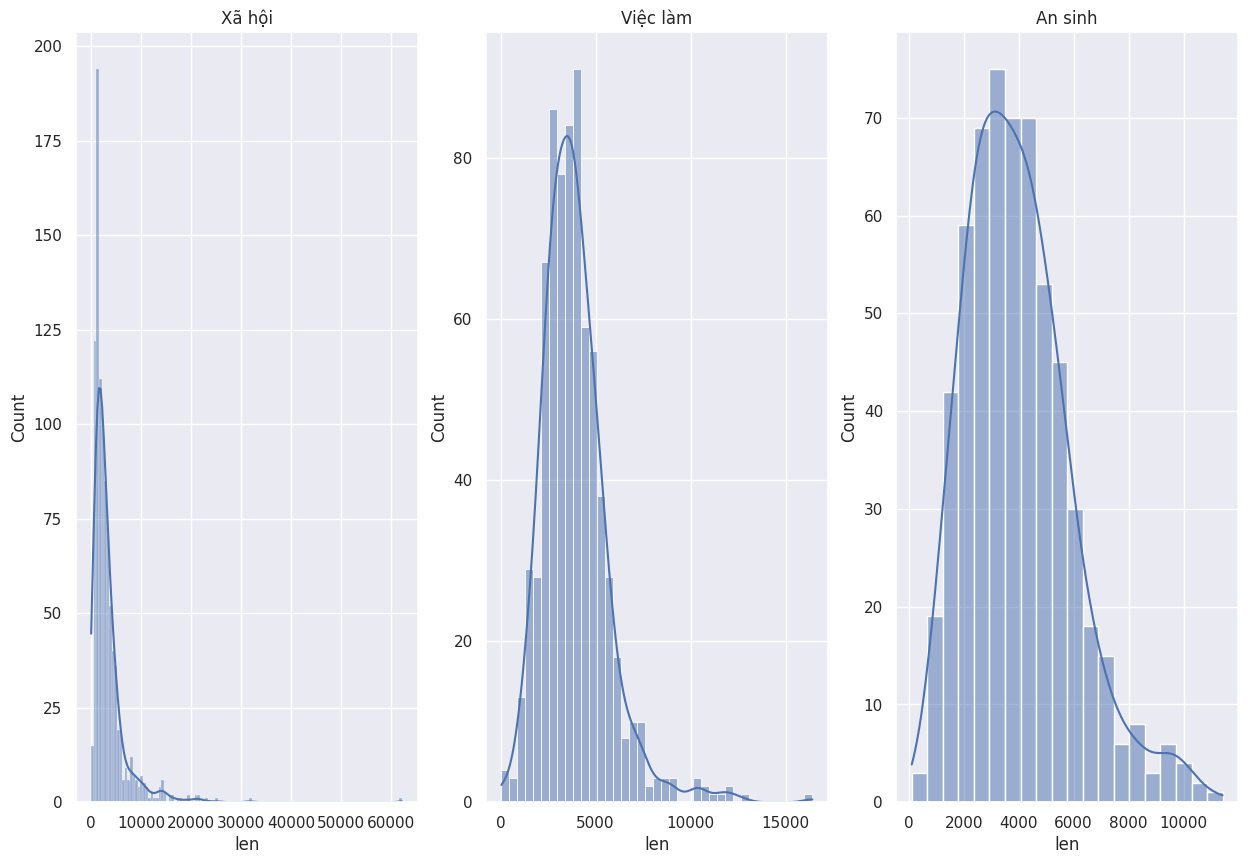

In [17]:
create_hist_plot(categories[:3], df=data)

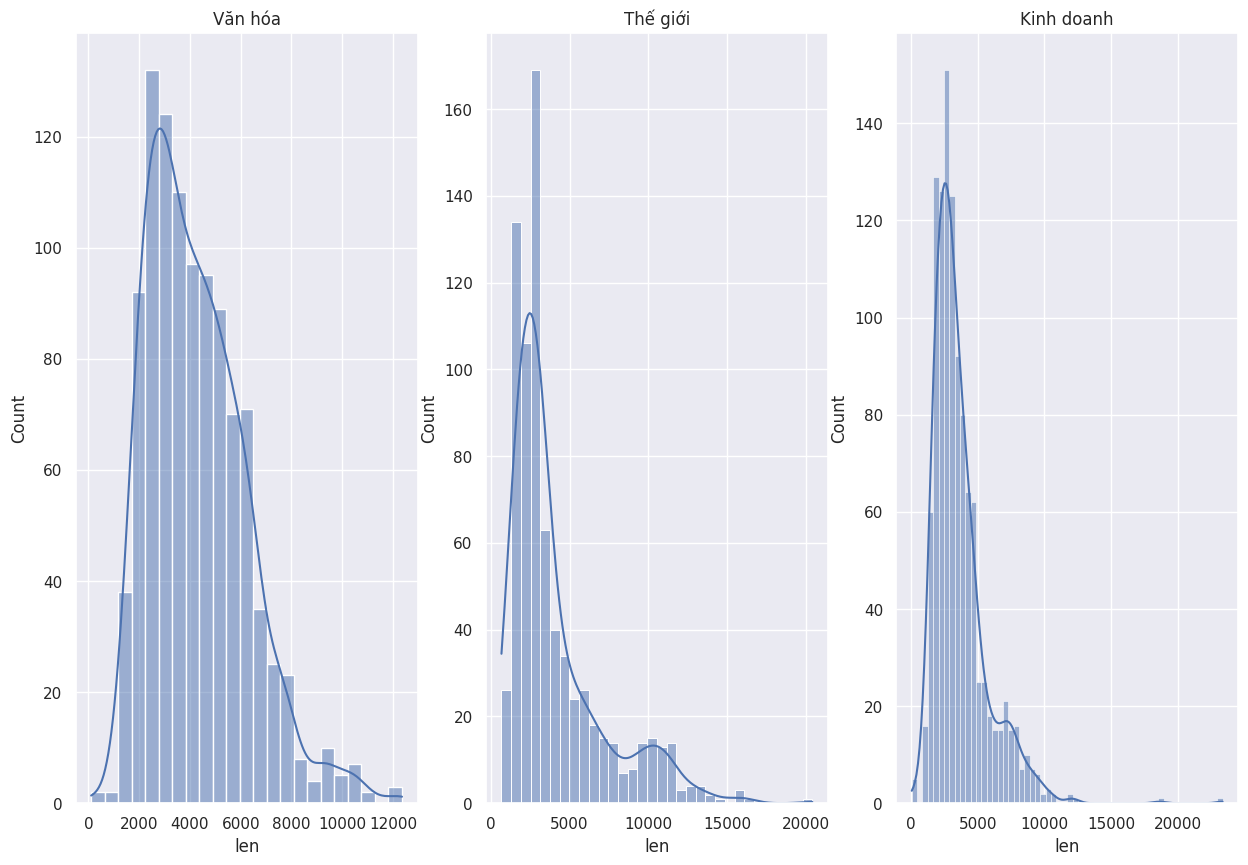

In [18]:
create_hist_plot(categories[3:6], df=data)


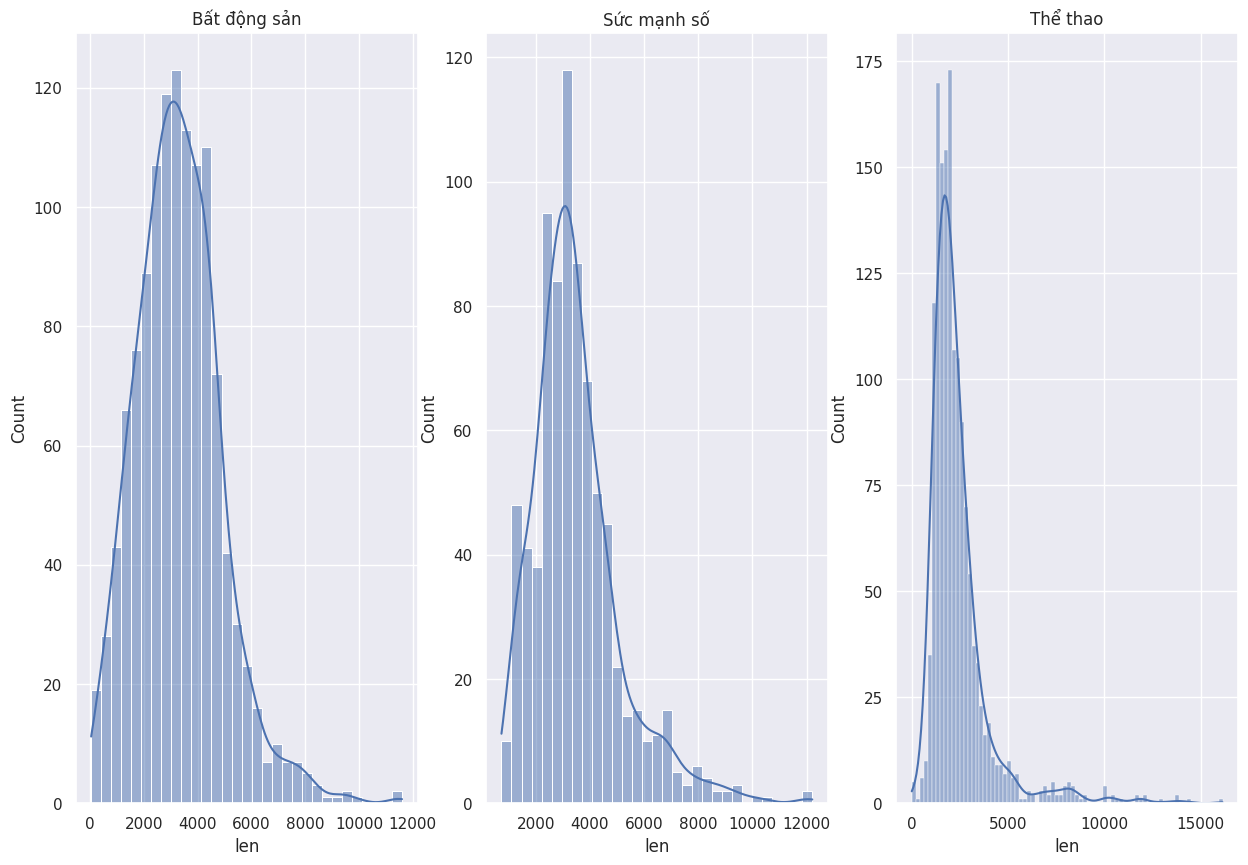

In [19]:
create_hist_plot(categories[6:9], df=data)


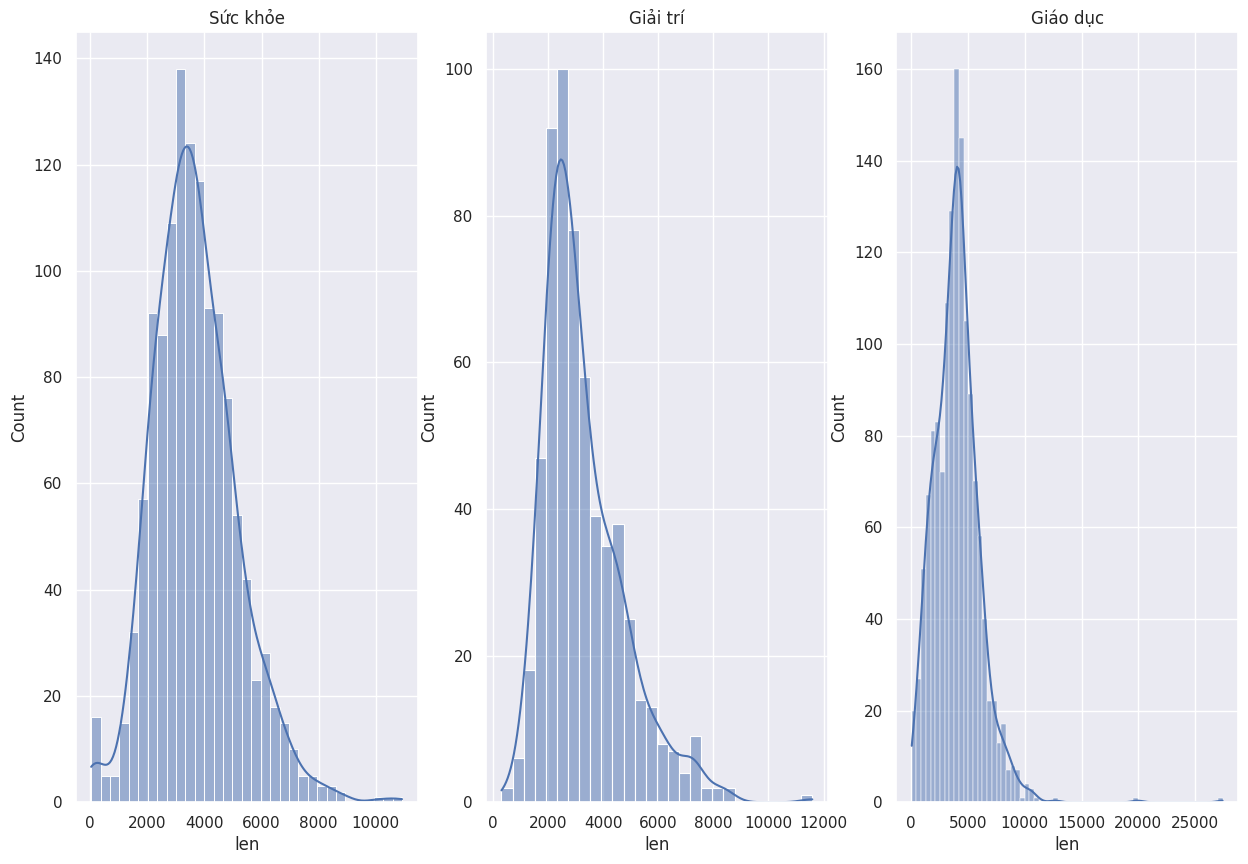

In [20]:
create_hist_plot(categories[9:12], df=data)


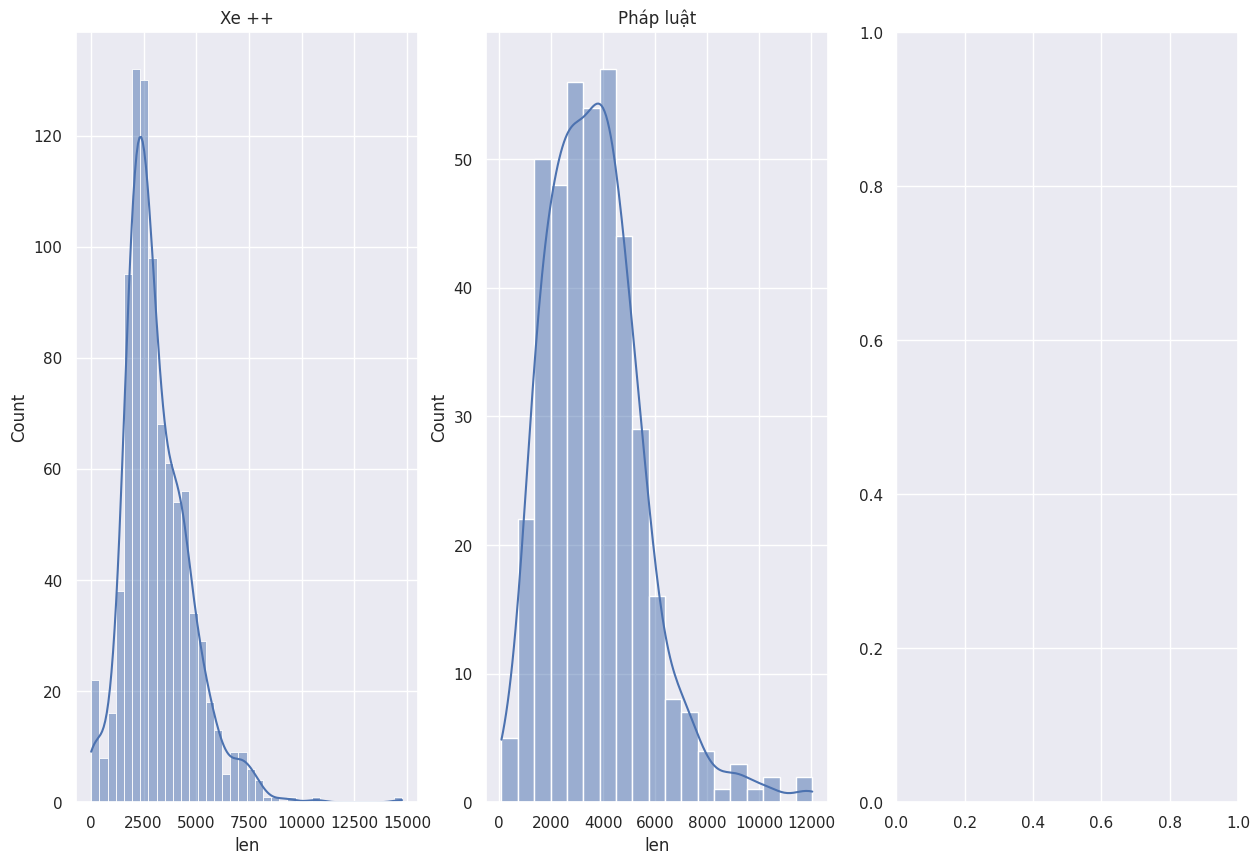

In [21]:
create_hist_plot(categories[12:14], df=data)


Từ các biểu đồ phân phối trên, ta nhận thấy rằng, hầu hết các hạng mục đều tuân theo dạng hình chuông (phân phối Gaussian). Theo lý thuyết, thường phân phối chuẩn sẽ tốt cho mô hình khi học

#### Text Cleaning
> Bình thường, trong tiếng Anh sẽ tách ra thành các từ đơn lẻ rồi chuyển sang dạng só thực một cách trực tiếp. Tuy nhiên, trong tiếng Việt sẽ có những từ phải đi cùng một cặp với nhau thì sẽ mang ý nghĩa rõ ràng hơn. Do đó cách xử lý sẽ khác so với tiếng Anh

In [22]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_texts = []
        for text in X:
            cleaned_text = self.clean_text(text)
            cleaned_texts.append(cleaned_text)
        return np.array(cleaned_texts)

    @staticmethod
    def clean_text(content: str):
        # Text Normalizer
        # lowercase content
        # content = content.lower()
        # # remove white space
        # content = " ".join([x for x in content.split()])
        # # remove punctuation and digits
        # content = content.translate(str.maketrans("", "", punc_custom)).translate(
        #     str.maketrans("", "", digits)
        # )

        # Sử dụng `gensim` để xử lý cơ bản text
        tokens = gensim.utils.simple_preprocess(content)
        content = " ".join(tokens)
        # tokenize content
        content = ViTokenizer.tokenize(content)

        return content

In [23]:
X, label = data['content'].values, data['category'].values

print(X.shape, label.shape)

(13331,) (13331,)


In [24]:
print(X[:2])
print(label[:2])

['Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng cục Thi hành án dân sự (Bộ Tư pháp) vừa ký ban hành kế hoạch công tác năm 2024 của Tổ công tác chỉ đạo xử lý các vụ việc liên quan đến hoạt động tín dụng, ngân hàng (Tổ xử lý nợ xấu). Tổ xử lý nợ xấu có trách nhiệm phối hợp với Vụ Pháp chế (Ngân hàng Nhà nước), Hiệp hội Ngân hàng tổ chức tọa đàm, đối thoại giữa các cơ quan thi hành án với tổ chức tín dụng, Công ty quản lý tài sản (VAMC) để trao đổi, tháo gỡ khó khăn, vướng mắc liên quan đến các vụ việc thi hành án tín dụng, ngân hàng. Trong đó, tập trung rà soát, tổng hợp các vụ việc trên cơ sở thông báo kết luận kiểm tra các năm 2022, 2023 hoặc đề nghị của Hiệp hội Ngân hàng, các tổ chức tín dụng, VAMC. "Phối hợp chỉ đạo tổ chức thi hành dứt điểm đối với những vụ việc có điều kiện, nhất là những đơn vị có nhiều vụ việc lớn, phức tạp liên quan đến các tổ chức tín dụng như Agribank, Vietcombank, VPBank, BIDV, Vietinbank", lãnh đạo Tổng cục Thi hành án dân sự nêu rõ. Ông Nguyễn Văn Sơn, Phó 

In [25]:
le = LabelEncoder()
y = le.fit_transform(label)

print(le.classes_)

['An sinh' 'Bất động sản' 'Giáo dục' 'Giải trí' 'Kinh doanh' 'Pháp luật'
 'Sức khỏe' 'Sức mạnh số' 'Thế giới' 'Thể thao' 'Việc làm' 'Văn hóa'
 'Xe ++' 'Xã hội']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Xây dựng tệp từ điển

Vì độ dài của các bài báo thường khá dài, từ các biểu đồ phân phối ở trên, chúng ta có thể thấy rằng, các bài báo thường từ 2000 từ trở lên, có nghĩa là nếu càng nhiều bài báo thì từ vựng càng nhiều, nếu mô tả một đoạn text theo tất cả các từ vựng đó thì ma trận sẽ rất lớn chưa kể đến việc nó là ma trận thưa (hầu hết là các giá trị 0)

In [29]:
# No Cleaner
# count_vectorizer_no_cleaner = CountVectorizer(stop_words=stopwords)
# count_vectorizer_no_cleaner.fit(X_train)
# MAX_FEATURES = len(count_vectorizer_no_cleaner.vocabulary_)

# With Cleaner
text_cleaner = TextCleaner()
count_vectorizer_with_cleaner = CountVectorizer(stop_words=stopwords)
X_train_with_cleaner = text_cleaner.fit_transform(X_train)
count_vectorizer_with_cleaner.fit(X_train_with_cleaner)
MAX_FEATURES_WITH_CLEANER = len(count_vectorizer_with_cleaner.vocabulary_)

In [30]:
MAX_FEATURES_WITH_CLEANER #, MAX_FEATURES

58373

#### Tạo Pipeline cho việc tiền xử lý dữ liệu text

In [32]:
def create_pipeline(stop_words, cleaner=False, percentage_feature=0.8):
  steps = []
  max_features = int(percentage_feature * (MAX_FEATURES_WITH_CLEANER ))#if cleaner else MAX_FEATURES))

  count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=max_features)
  if cleaner:
    text_cleaner = TextCleaner()
    steps.append(('cleaner', text_cleaner))

  # Add steps to convert text to matrix
  steps.append(('count_vectorizer', count_vectorizer))
  steps.append(('tfidf_transformer', TfidfTransformer()))

  return Pipeline(steps), max_features



#### Chuyển dữ liệu dạng text sang dạng ma trận
Chúng ta sẽ giữ lại khoảng 60% từ vựng, việc giảm số từ vựng xuống giúp cho mô hình giảm độ phức tạp, và chi phí tính toán được giảm thiểu

> Đối với các mô hình Machine Learning, nó có thể *linh hoạt* hơn khi đào tạo với ma trận có kích thước cỡ lớn. Tuy nhiên, vì chúng ta có mục tiêu sẽ `thử` ứng dụng các mô hình **Deep Learning** như CNN và LSTM để **so sánh** hiệu suất giữa **Machine Learning** và **Deep Learning** nên việc **giảm chiều dữ liệu** là vô cùng cần thiết, vì nếu chúng ta đưa quá nhiều Input vào mô hình Neural Networks thì mô hình sẽ có độ phức tạp cao và chi phí tính toán "đắt đỏ"

In [33]:
pipeline_cleaner, max_features = create_pipeline(stopwords, cleaner=True, percentage_feature=0.6)

In [34]:
# transform train and test set
X_train_processed_cleaner = pipeline_cleaner.fit_transform(X_train)
X_test_processed_cleaner = pipeline_cleaner.transform(X_test)

In [35]:
max_features

35023

## Phần II: Thử nghiệm

### Xây dựng mô hình học máy
> Đầu tiên, chúng ta sẽ liệt kê các mô hình học máy sẽ sử dụng trong bài toán và đào tạo trực tiếp trên tập train trước khi dùng các kĩ thuật **Cross-Validation** để tăng hiệu suất của các mô hình

In [36]:
def evaluation_model(y_pred, y_test):
  print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
  print(classification_report(y_test, y_pred, target_names=le.classes_))

#### Mô hình SVM

In [37]:
X_train_processed_cleaner.shape, y_train.shape

((10664, 35023), (10664,))

In [38]:
svc = SVC(C=1.0, kernel='linear')

svc.fit(X_train_processed_cleaner, y_train)

SVC(kernel='linear')

In [39]:
y_pred = svc.predict(X_test_processed_cleaner)

evaluation_model(y_pred, y_test)

- Acc = 0.8965129358830146
              precision    recall  f1-score   support

     An sinh       0.78      0.69      0.73       116
Bất động sản       0.91      0.93      0.92       260
    Giáo dục       0.89      0.94      0.91       256
    Giải trí       0.83      0.78      0.80       128
  Kinh doanh       0.85      0.87      0.86       205
   Pháp luật       0.94      0.96      0.95        80
    Sức khỏe       0.95      0.97      0.96       234
 Sức mạnh số       0.92      0.93      0.93       167
    Thế giới       0.95      0.81      0.87       154
    Thể thao       0.98      0.98      0.98       283
    Việc làm       0.87      0.76      0.81       170
     Văn hóa       0.85      0.89      0.87       225
       Xe ++       0.93      0.99      0.96       187
      Xã hội       0.84      0.86      0.85       202

    accuracy                           0.90      2667
   macro avg       0.89      0.88      0.89      2667
weighted avg       0.90      0.90      0.90      2667

#### Mô hình SGD

In [61]:
sgd = SGDClassifier(max_iter=1000, n_jobs=3, early_stopping=True, eta0=0.001)

sgd.fit(X_train_processed_cleaner, y_train)

SGDClassifier(early_stopping=True, eta0=0.001, n_jobs=3)

In [62]:
y_pred = sgd.predict(X_test_processed_cleaner)

evaluation_model(y_pred, y_test)

- Acc = 0.8983877015373078
              precision    recall  f1-score   support

     An sinh       0.85      0.77      0.81       116
Bất động sản       0.90      0.94      0.92       260
    Giáo dục       0.90      0.94      0.92       256
    Giải trí       0.81      0.79      0.80       128
  Kinh doanh       0.85      0.85      0.85       205
   Pháp luật       0.95      0.95      0.95        80
    Sức khỏe       0.95      0.97      0.96       234
 Sức mạnh số       0.91      0.93      0.92       167
    Thế giới       0.93      0.81      0.87       154
    Thể thao       0.98      0.98      0.98       283
    Việc làm       0.89      0.79      0.84       170
     Văn hóa       0.84      0.89      0.86       225
       Xe ++       0.92      0.99      0.95       187
      Xã hội       0.86      0.83      0.84       202

    accuracy                           0.90      2667
   macro avg       0.89      0.89      0.89      2667
weighted avg       0.90      0.90      0.90      2667

#### Mô hình Bayesian

##### Multinomial Naive Bayes

In [70]:
mul_nb = MultinomialNB()
mul_nb.fit(X_train_processed_cleaner, y_train)

MultinomialNB()

In [71]:
y_pred = mul_nb.predict(X_test_processed_cleaner)

evaluation_model(y_pred, y_test)

- Acc = 0.7997750281214848
              precision    recall  f1-score   support

     An sinh       0.90      0.30      0.45       116
Bất động sản       0.77      0.93      0.84       260
    Giáo dục       0.61      0.99      0.75       256
    Giải trí       0.92      0.38      0.53       128
  Kinh doanh       0.75      0.81      0.78       205
   Pháp luật       0.98      0.60      0.74        80
    Sức khỏe       0.91      0.97      0.94       234
 Sức mạnh số       0.92      0.76      0.83       167
    Thế giới       0.95      0.59      0.73       154
    Thể thao       0.96      0.97      0.96       283
    Việc làm       0.86      0.43      0.57       170
     Văn hóa       0.70      0.91      0.79       225
       Xe ++       0.93      0.96      0.94       187
      Xã hội       0.70      0.81      0.75       202

    accuracy                           0.80      2667
   macro avg       0.85      0.74      0.76      2667
weighted avg       0.83      0.80      0.79      2667

##### Gaussian Naive Bayes

In [68]:
gau_nb = GaussianNB()
gau_nb.fit(X_train_processed_cleaner.toarray(), y_train)

GaussianNB()

In [73]:
y_pred = gau_nb.predict(X_test_processed_cleaner.toarray())

evaluation_model(y_pred, y_test)

- Acc = 0.7416572928383952
              precision    recall  f1-score   support

     An sinh       0.44      0.40      0.42       116
Bất động sản       0.79      0.72      0.76       260
    Giáo dục       0.65      0.80      0.72       256
    Giải trí       0.72      0.52      0.60       128
  Kinh doanh       0.69      0.71      0.70       205
   Pháp luật       0.88      0.62      0.73        80
    Sức khỏe       0.93      0.90      0.92       234
 Sức mạnh số       0.90      0.77      0.83       167
    Thế giới       0.86      0.70      0.77       154
    Thể thao       0.92      0.94      0.93       283
    Việc làm       0.61      0.48      0.54       170
     Văn hóa       0.52      0.85      0.64       225
       Xe ++       0.93      0.86      0.89       187
      Xã hội       0.68      0.65      0.66       202

    accuracy                           0.74      2667
   macro avg       0.75      0.71      0.72      2667
weighted avg       0.76      0.74      0.74      2667

#### Mô hình Decision Tree

In [84]:
dt = DecisionTreeClassifier(max_depth=5000)
dt.fit(X_train_processed_cleaner, y_train)

DecisionTreeClassifier(max_depth=5000)

In [86]:
y_pred = dt.predict(X_test_processed_cleaner)

evaluation_model(y_pred, y_test)

- Acc = 0.6887889013873266
              precision    recall  f1-score   support

     An sinh       0.39      0.39      0.39       116
Bất động sản       0.70      0.72      0.71       260
    Giáo dục       0.71      0.77      0.74       256
    Giải trí       0.56      0.52      0.54       128
  Kinh doanh       0.56      0.61      0.58       205
   Pháp luật       0.87      0.69      0.77        80
    Sức khỏe       0.83      0.86      0.84       234
 Sức mạnh số       0.67      0.68      0.67       167
    Thế giới       0.65      0.54      0.59       154
    Thể thao       0.86      0.90      0.88       283
    Việc làm       0.57      0.46      0.51       170
     Văn hóa       0.66      0.70      0.68       225
       Xe ++       0.84      0.87      0.85       187
      Xã hội       0.56      0.56      0.56       202

    accuracy                           0.69      2667
   macro avg       0.67      0.66      0.67      2667
weighted avg       0.69      0.69      0.69      2667